# Reversal Trading Using Correlated Triples

We seek triples of coins such that the behavior of the return of one is modeled well by a function of the return of the other two based on a linear regression model. For a given coin, our approach involves finding one coin which has correlated returns and then finding a second coin which also has returns which are correlated with the first coin but which has returns which are **not** highly correlated with those of the second coin.

If we can find such a pair, we use a linear regression model to predict the returns of the first coin from the previous returns of the two separately correlated coins. When we observe a deviation in the dependent coin from what is predicted by our model, we predict reversal and long the under-priced asset(s) and short the over-priced asset(s).

We dynamically re-select triples of correlated coins in a given look-back window and test different parameters for selecting coins on the in-sample data and report the results for the out-sample data. Parameters that we vary include:
- **P1**: Threshold for minimum allowable correlation of a second coin with the first coin
- **P2**: Threshold for maximum allowable correlation of the third coin with the second coin
- **P3**: Threshold for discarding the triple of coins as a correlated tuple: when the correlation between the first coin and either the second or third coin falls below this value, discard the triple.
- **P4**: z-score minimum threshold: the lowest z-score in the trailing window of data on returns allowed which we would use as a signal that there is a deviation which will reverse (i.e. when we should long/short the triple)
- **P5**: Data frequency: there is a trade off between how recent the data is and how much turnover there is in the portfolio (which affects transaction costs).

Data used is over the following period:
- in-sample period: 2020-01-01 00:00:00 to 2022-12-31 20:00:00
- out-sample period: 2023-01-01 00:00:00 to 2025-02-20 00:00:00

The table below shows a summary of the parameters tested which had positive Sharpe ratios in both the in-sample period and the out-sample period:

 P1 |  P2      |  P3      | P4    |  P5   |  total sr  |  in-sample sr  |  out-sample sr |
:-- | :------: | :------: | :---: | :----:| :---------:| :-------------:| :-------------:|
0.7 | 0.7      |   0.5    | 2.0   |  1d   |  0.722146  |  0.320903      |  1.184643      |
0.7 | 0.7      |   0.5    | 2.5   |  1d   |  0.729000  |  0.471918      |  1.021087      |
0.7 | 0.7      |   0.5    | 3.0   |  1d   |  0.816588  |  0.811953      |  0.849927      |
0.6 | 0.6      |   0.5    | 3.0   |  1d   |  0.889890  |  0.327398      |  1.437061      |
0.6 | 0.6      |   0.5    | 3.5   |  1d   |  0.614401  |  0.116586      |  1.125970      |

The best and most consistent results based on the in-sample period are from the first row, with a total Sharpe ratio of 0.816588, an in-sample Sharpe ratio of 0.811953, and an out-sample Sharpe ratio of 0.849927. Also, the fourth row had the best out-sample Sharpe ratio of 1.437061.

# Coin Universe

We use a historical snapshot of coins from [December 01, 2019](https://coinmarketcap.com/historical/20191201/) to get a representative set of coins from before the period of analysis to avoid look-ahead bias.

In [1]:
strat_univ = [
    'BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'BCHUSDT', 'LTCUSDT', 'EOSUSDT', 'BNBUSDT',
    'XLMUSDT', 'TRXUSDT', 'ADAUSDT', 'XTZUSDT', 'LINKUSDT', 'ATOMUSDT',
    'NEOUSDT', 'MKRUSDT', 'DASHUSDT', 'ETCUSDT', 'USDCUSDT', 'ONTUSDT', 'VETUSDT',
    'DOGEUSDT', 'BATUSDT', 'ZECUSDT',
    'SNXUSDT', 'QTUMUSDT', 'TUSDUSDT', 'ZRXUSDT',
    'THXUSDT', 'THRUSDT', 'ALGOUSDT', 'REPUSDT', 'NANOUSDT', 'KBCUSDT', 'BTGUSDT', 'RVNUSDT', 'OMGUSDT',
    'CNXUSDT', 'ABBCUSDT', 'XINUSDT', 'VSYSUSDT', 'SEELEUSDT', 'EONUSDT', 'ZBUSDT', 'EKTUSDT', 'DGBUSDT',
    'BTMUSDT', 'LSKUSDT', 'KMDUSDT', 'SAIUSDT', 'LUNAUSDT', 'KCSUSDT', 'FTTUSDT', 'QNTUSDT', 'SXPUSDT',
    'BDXUSDT', 'GAPUSDT', 'BCDUSDT', 'THETAUSDT', 'ICXUSDT', 'FSTUSDT', 'MATICUSDT', 'SCUSDT', 'EVRUSDT',
    'BTTUSDT', 'MOFUSDT', 'IOSTUSDT', 'MCOUSDT', 'WAVESUSDT', 'XVGUSDT', 'MONAUSDT', 'BTSUSDT', 'BCNUSDT',
    'HCUSDT', 'MAIDUSDT', 'NEXOUSDT', 'ARDRUSDT', 'DXUSDT', 'OKBUSDT', 'FXCUSDT', 'RLCUSDT', 'MBUSDT',
    'BXKUSDT', 'AEUSDT', 'ENJUSDT', 'STEEMUSDT', 'SLVUSDT', 'BRZEUSDT', 'ZILUSDT', 'VESTUSDT', 'ZENUSDT',
    'SOLVEUSDT', 'CHZUSDT', 'NOAHUSDT', 'LAUSDT', 'BTMXUSDT', 'ETNUSDT', 'ENGUSDT', 'ILCUSDT', 'NPXSUSDT',
    'CRPTUSDT', 'GNTUSDT', 'SNTUSDT', 'ELFUSDT', 'JWLUSDT', 'FETUSDT', 'BOTXUSDT', 'NRGUSDT', 'DGDUSDT',
    'EXMRUSDT', 'EURSUSDT', 'AOAUSDT', 'RIFUSDT', 'CIX100USDT', 'BFUSDT', 'XZCUSDT', 'FABUSDT', 'GRINUSDT',
    'NETUSDT', 'VERIUSDT', 'DGTXUSDT', 'KNCUSDT', 'RENUSDT', 'STRATUSDT', 'ETPUSDT', 'NEXUSDT', 'NEWUSDT',
    'BCZEROUSDT', 'GXCUSDT', 'TNTUSDT', 'BTC2USDT', 'PPTUSDT', 'USDKUSDT', 'ELAUSDT', 'IGNISUSDT', 'PLCUSDT',
    'BNKUSDT', 'DTRUSDT', 'RCNUSDT', 'HPTUSDT', 'LAMBUSDT', 'MANAUSDT', 'EDCUSDT', 'BEAMUSDT', 'TTUSDT',
    'AIONUSDT', 'BZUSDT', 'WTCUSDT', 'WICCUSDT', 'LRCUSDT', 'BRDUSDT', 'FCTUSDT', 'NULSUSDT', 'FTMUSDT',
    'IOTXUSDT', 'QBITUSDT', 'XMXUSDT', 'YOUUSDT', 'NASUSDT', 'WAXPUSDT', 'ARKUSDT', 'RDDUSDT', 'GNYUSDT',
    'AGVCUSDT', 'HYNUSDT', 'CVCUSDT', 'WANUSDT', 'WINUSDT', 'LINAUSDT', 'RUSDT', 'PAIUSDT', 'FSNUSDT',
    'FUNUSDT', 'DPTUSDT', 'BHDUSDT', 'LOOMUSDT', 'XACUSDT', 'BUSDUSDT', 'BHPUSDT', 'TRUEUSDT', 'LOKIUSDT',
    'QASHUSDT', 'BNTUSDT', 'DOTUSDT', 'SOLUSDT']

# Load And Structure Data - 4-Hour Frequency

We extract closing prices over the interval from 2020-01-01 00:00:00 to 2025-02-20 08:00:00 with a frequency of 4 hours.

In [2]:
from binance.client import Client as bnb_client
from binance.client import BinanceAPIException
from datetime import datetime
import pandas as pd

client = bnb_client(tld='US')

def get_price_data_for_coin(coin, freq, start_datetime, end_datetime):
    bn_data = client.get_historical_klines(coin, freq, start_datetime, end_datetime)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
        'num_trades','taker_base_volume','taker_quote_volume','ignore']

    bn_data = pd.DataFrame(bn_data, columns=columns)
    bn_data['open_time'] = bn_data['open_time'].map(lambda x: datetime.utcfromtimestamp(x / 1000))
    bn_data['close_time'] = bn_data['close_time'].map(lambda x: datetime.utcfromtimestamp(x / 1000))
    return bn_data


def get_price_data_for_universe(freq, start_datetime, end_datetime):
    px_data = {}

    for coin in strat_univ:
        try:
            px_data[coin] = get_price_data_for_coin(
                coin, freq, start_datetime, end_datetime).set_index('open_time')
            print(f"Downloaded data for {coin}.")
        except BinanceAPIException:
            print(f"Couldn't load data for {coin}.")
    
    return px_data

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
data_freq = '4h'
num_day_periods = 6

look_back_window_size = 30 * 6
look_back_min_periods = 10 * 6
start_datetime = '2020-01-01 00:00:00'
end_datetime = '2025-02-20 08:00:00'
out_sample_start_datetime = pd.to_datetime("2023-01-01 00:00:00")

In [5]:
px_data_4h = get_price_data_for_universe(data_freq, start_datetime, end_datetime)

Downloaded data for BTCUSDT.
Downloaded data for ETHUSDT.
Downloaded data for XRPUSDT.
Downloaded data for BCHUSDT.
Downloaded data for LTCUSDT.
Downloaded data for EOSUSDT.
Downloaded data for BNBUSDT.
Downloaded data for XLMUSDT.
Downloaded data for TRXUSDT.
Downloaded data for ADAUSDT.
Downloaded data for XTZUSDT.
Downloaded data for LINKUSDT.
Downloaded data for ATOMUSDT.
Downloaded data for NEOUSDT.
Downloaded data for MKRUSDT.
Downloaded data for DASHUSDT.
Downloaded data for ETCUSDT.
Downloaded data for USDCUSDT.
Downloaded data for ONTUSDT.
Downloaded data for VETUSDT.
Downloaded data for DOGEUSDT.
Downloaded data for BATUSDT.
Downloaded data for ZECUSDT.
Downloaded data for SNXUSDT.
Downloaded data for QTUMUSDT.
Downloaded data for TUSDUSDT.
Downloaded data for ZRXUSDT.
Couldn't load data for THXUSDT.
Couldn't load data for THRUSDT.
Downloaded data for ALGOUSDT.
Couldn't load data for REPUSDT.
Couldn't load data for NANOUSDT.
Couldn't load data for KBCUSDT.
Couldn't load data 

In [6]:
px_close_4h = {coin: px_data_4h[coin]["close"] for coin in px_data_4h}
px_close_4h = pd.DataFrame(px_close_4h).astype(float)
px_close_4h.index.rename("datetime", inplace=True)

px_close_4h

,BTCUSDT,ETHUSDT,XRPUSDT,BCHUSDT,LTCUSDT,EOSUSDT,BNBUSDT,XLMUSDT,TRXUSDT,ADAUSDT,...,MANAUSDT,LRCUSDT,FTMUSDT,IOTXUSDT,WAXPUSDT,LOOMUSDT,BUSDUSDT,BNTUSDT,DOTUSDT,SOLUSDT
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,7230.71,130.18,0.19406,205.64,41.58,NaN,13.8159,0.04515,NaN,0.03308,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,7205.50,130.52,0.19518,206.72,41.55,NaN,13.7648,0.04493,NaN,0.03320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 08:00:00,7195.80,130.84,0.19358,205.61,41.67,NaN,13.7162,0.04509,NaN,0.03321,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 12:00:00,7233.02,131.84,0.19428,206.63,41.89,NaN,13.7958,0.04542,NaN,0.03357,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 16:00:00,7223.72,131.98,0.19474,206.35,41.79,NaN,13.7270,0.04547,NaN,0.03361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-19 16:00:00,96235.29,2709.46,2.66600,321.30,135.19,0.5836,651.2500,0.33390,NaN,0.75890,...,0.3119,0.1309,0.6902,0.02921,0.03003,0.04663,NaN,0.577,4.878,168.79
2025-02-19 20:00:00,96650.01,2715.33,2.74310,322.90,135.10,0.5836,654.3400,0.34200,NaN,0.77420,...,0.3118,0.1304,0.7158,0.02936,0.03005,0.04663,NaN,0.577,4.851,169.00
2025-02-20 00:00:00,97040.40,2743.25,2.71250,325.30,133.33,0.6427,654.7100,0.34070,NaN,0.78140,...,0.3225,0.1320,0.7221,0.02936,0.03005,0.04663,NaN,0.577,4.905,172.56


# Load And Structure Data - 8-Hour Frequency

We extract closing prices over the interval from 2020-01-01 00:00:00 to 2025-02-20 08:00:00 with a frequency of 4 hours.

In [23]:
data_freq = '8h'
num_day_periods = 3

look_back_window_size = 30 * 6
look_back_min_periods = 10 * 6
start_datetime = '2020-01-01 00:00:00'
end_datetime = '2025-02-20 08:00:00'
out_sample_start_datetime = pd.to_datetime("2023-01-01 00:00:00")

In [24]:
px_data_8h = get_price_data_for_universe(data_freq, start_datetime, end_datetime)

Downloaded data for BTCUSDT.
Downloaded data for ETHUSDT.
Downloaded data for XRPUSDT.
Downloaded data for BCHUSDT.
Downloaded data for LTCUSDT.
Downloaded data for EOSUSDT.
Downloaded data for BNBUSDT.
Downloaded data for XLMUSDT.
Downloaded data for TRXUSDT.
Downloaded data for ADAUSDT.
Downloaded data for XTZUSDT.
Downloaded data for LINKUSDT.
Downloaded data for ATOMUSDT.
Downloaded data for NEOUSDT.
Downloaded data for MKRUSDT.
Downloaded data for DASHUSDT.
Downloaded data for ETCUSDT.
Downloaded data for USDCUSDT.
Downloaded data for ONTUSDT.
Downloaded data for VETUSDT.
Downloaded data for DOGEUSDT.
Downloaded data for BATUSDT.
Downloaded data for ZECUSDT.
Downloaded data for SNXUSDT.
Downloaded data for QTUMUSDT.
Downloaded data for TUSDUSDT.
Downloaded data for ZRXUSDT.
Couldn't load data for THXUSDT.
Couldn't load data for THRUSDT.
Downloaded data for ALGOUSDT.
Couldn't load data for REPUSDT.
Couldn't load data for NANOUSDT.
Couldn't load data for KBCUSDT.
Couldn't load data 

In [25]:
px_close_8h = {coin: px_data_8h[coin]["close"] for coin in px_data_8h}
px_close_8h = pd.DataFrame(px_close_8h).astype(float)
px_close_8h.index.rename("datetime", inplace=True)

px_close_8h

,BTCUSDT,ETHUSDT,XRPUSDT,BCHUSDT,LTCUSDT,EOSUSDT,BNBUSDT,XLMUSDT,TRXUSDT,ADAUSDT,...,MANAUSDT,LRCUSDT,FTMUSDT,IOTXUSDT,WAXPUSDT,LOOMUSDT,BUSDUSDT,BNTUSDT,DOTUSDT,SOLUSDT
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,7205.50,130.52,0.19518,206.72,41.55,NaN,13.7648,0.04493,NaN,0.03320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 08:00:00,7233.02,131.84,0.19428,206.63,41.89,NaN,13.7958,0.04542,NaN,0.03357,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 16:00:00,7195.65,130.52,0.19301,204.31,41.53,NaN,13.6954,0.04525,NaN,0.03346,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 00:00:00,7114.66,129.03,0.19108,201.13,41.21,NaN,13.4469,0.04502,NaN,0.03303,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 08:00:00,7131.26,129.10,0.19205,203.52,41.11,NaN,13.3810,0.04490,NaN,0.03324,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-19 00:00:00,95719.30,2709.39,2.55850,319.80,135.23,0.5837,655.1700,0.33220,NaN,0.76530,...,0.3191,0.1309,0.6454,0.02875,0.03400,0.04663,NaN,0.577,4.767,169.52
2025-02-19 08:00:00,95999.77,2696.23,2.60550,318.90,136.10,0.5837,651.2300,0.33230,NaN,0.75830,...,0.3120,0.1309,0.6908,0.02878,0.03003,0.04663,NaN,0.577,4.821,169.49
2025-02-19 16:00:00,96650.01,2715.33,2.74310,322.90,135.10,0.5836,654.3400,0.34200,NaN,0.77420,...,0.3118,0.1304,0.7158,0.02936,0.03005,0.04663,NaN,0.577,4.851,169.00


# Define Functions For Picking Coins And Setting Holdings

In [7]:
import numpy as np
import statsmodels.api as sm
from enum import Enum

class CorrSelectionMethod(Enum):
    MAX_CORR = 1
    MIN_CORR = 2


def get_newly_uncorrelated_keys(current_correlated_triples, price_indicator_window_df,
                                corr_matrix, rejection_max_corr):
    newly_uncorrelated_keys = set()
    for key_coin in current_correlated_triples:
        value_coin_1 = current_correlated_triples[key_coin].columns[0]
        value_coin_2 = current_correlated_triples[key_coin].columns[1]
        triple_list = [key_coin, value_coin_1, value_coin_2]
        
        # if any of the coins do not have data (e.g. if the coin no longer exists)
        if price_indicator_window_df[triple_list].iloc[-1].isnull().any():
            newly_uncorrelated_keys.add(key_coin)
        elif ((corr_matrix.loc[key_coin, value_coin_1] < rejection_max_corr or \
               corr_matrix.loc[key_coin, value_coin_2] < rejection_max_corr)):
            newly_uncorrelated_keys.add(key_coin)
    return newly_uncorrelated_keys


def remove_uncorrelated_keys(newly_uncorrelated_keys, coins_in_a_triple, current_correlated_triples):
    for coin in newly_uncorrelated_keys:
        coins_in_a_triple.remove(coin)
        coins_in_a_triple.remove(current_correlated_triples[coin].columns[0])
        coins_in_a_triple.remove(current_correlated_triples[coin].columns[1])
        
        if coin in current_correlated_triples: # only the dependent coin will appears as a key
            del current_correlated_triples[coin]


def update_correlated_coins(coin, corr_matrix, coins_in_a_triple, current_correlated_triples,
                            price_indicator_window_df, secondary_coin_min_corr, tertiary_coin_max_corr):
    largest_corr = -1.0
    secondary_coin = None
    for other_coin, other_coin_value in corr_matrix[coin][corr_matrix[coin] > secondary_coin_min_corr].items():
        if np.isnan(price_indicator_window_df[other_coin]).any():
            continue
        elif other_coin in coins_in_a_triple:
            continue
        elif other_coin != coin and corr_matrix.loc[coin, other_coin] >= largest_corr:
            largest_corr = corr_matrix.loc[coin, other_coin]
            secondary_coin = other_coin
    
    if secondary_coin is None:
        return
    
    tertiary_coin = None
    correlation_to_secondary_coin = 1.0
    for other_coin, other_coin_value in corr_matrix[coin][corr_matrix[coin] > secondary_coin_min_corr].items():
        if np.isnan(price_indicator_window_df[other_coin]).any():
            continue
        elif other_coin in coins_in_a_triple:
            continue
        elif (
            other_coin != coin and \
            other_coin != secondary_coin and \
            corr_matrix.loc[secondary_coin, other_coin] < tertiary_coin_max_corr and \
            corr_matrix.loc[secondary_coin, other_coin] < correlation_to_secondary_coin):
            correlation_to_secondary_coin = corr_matrix.loc[secondary_coin, other_coin]
            tertiary_coin = other_coin
            
    if tertiary_coin is None:
        return
    
    coins_in_a_triple.add(coin)
    coins_in_a_triple.add(secondary_coin)
    coins_in_a_triple.add(tertiary_coin)
    current_correlated_triples[coin] = pd.DataFrame(
        0.0, columns=[secondary_coin, tertiary_coin, 'alpha', 'residual'], index=[])


def update_correlated_triples(current_correlated_triples, coins_in_a_triple, corr_matrix, 
                              price_indicator_window_df, secondary_coin_min_corr, tertiary_coin_max_corr):
    for coin in list(price_indicator_window_df.columns):
        if (coin not in coins_in_a_triple):
            update_correlated_coins(
                coin,
                corr_matrix,
                coins_in_a_triple,
                current_correlated_triples,
                price_indicator_window_df,
                secondary_coin_min_corr,
                tertiary_coin_max_corr
            )


def set_time_holdings(holdings_df, time_index, price_indicator_window_df, current_correlated_triples,
                      min_data_points_to_transact, look_back_window_size, z_score_min_threshold,
                      z_score_max_threshold):
    for coin in current_correlated_triples:
        independent_coin_1 = current_correlated_triples[coin].columns[0]
        independent_coin_2 = current_correlated_triples[coin].columns[1]
        
        model = sm.OLS(
            price_indicator_window_df[coin].iloc[:-1],
            sm.add_constant(price_indicator_window_df[[independent_coin_1, independent_coin_2]].iloc[:-1])
        )
        
        result = model.fit()
        result_data = {
            independent_coin_1: result.params[independent_coin_1],
            independent_coin_2: result.params[independent_coin_2],
            'alpha': result.params['const']
        }
        
        estimate = model.predict(
            result.params,
            sm.add_constant(
                price_indicator_window_df[[independent_coin_1, independent_coin_2]]).iloc[-1]
        )
        result_data['residual'] = price_indicator_window_df[coin].iloc[-1] - estimate
        result_series = pd.Series(result_data)
        current_correlated_triples[coin].loc[time_index] = result_series
        
        if len(current_correlated_triples[coin]) >= min_data_points_to_transact:
            z_score_look_back_len = min(look_back_window_size, len(current_correlated_triples[coin]))
            look_back_coin_regression_data = current_correlated_triples[coin].iloc[(-z_score_look_back_len):]
            residual_mean = look_back_coin_regression_data['residual'].mean()
            residual_std = look_back_coin_regression_data['residual'].std()
            z_score = (result_data['residual'] - residual_mean) / residual_std
            
            if z_score_min_threshold <= z_score <= z_score_max_threshold:
                holdings_df.loc[time_index, coin] = -1.0
                holdings_df.loc[time_index, independent_coin_1] = result_data[independent_coin_1]
                holdings_df.loc[time_index, independent_coin_2] = result_data[independent_coin_2]
            elif -z_score_max_threshold <= z_score <= -z_score_min_threshold:
                holdings_df.loc[time_index, coin] = 1.0
                holdings_df.loc[time_index, independent_coin_1] = -result_data[independent_coin_1]
                holdings_df.loc[time_index, independent_coin_2] = -result_data[independent_coin_2]

    holdings_df.loc[time_index] = holdings_df.loc[time_index] / holdings_df.loc[time_index].abs().sum()


def get_holdings_df(
    price_indicator_df,
    look_back_min_periods,
    look_back_window_size,
    secondary_coin_min_corr,
    tertiary_coin_max_corr,
    rejection_max_corr,
    min_data_points_to_transact,
    z_score_min_threshold,
    z_score_max_threshold):
    
    holdings_df = pd.DataFrame(0.0, columns=price_indicator_df.columns, index=price_indicator_df.index)
    
    current_correlated_triples = dict()
    coins_in_a_triple = set()
    
    for index in range(look_back_min_periods, len(holdings_df)):
        window_start = max(index-look_back_window_size, 0)
        
        # exclude the data from the current index itself to avoid having to shift forward strategy holdings
        # later when calculating returns to avoid look-ahead bias
        price_indicator_window_df = price_indicator_df.iloc[window_start:index]
        
        time_index = price_indicator_df.index[index]
        holdings_df.loc[time_index] = pd.Series(0.0, index=holdings_df.columns)
        
        corr_matrix = price_indicator_window_df.corr()
        
        newly_uncorrelated_keys = get_newly_uncorrelated_keys(
            current_correlated_triples,
            price_indicator_window_df,
            corr_matrix,
            rejection_max_corr)
        
        # update coins_in_a_triple and current_correlated_triples in-place
        remove_uncorrelated_keys(newly_uncorrelated_keys, coins_in_a_triple, current_correlated_triples)

        update_correlated_triples(
            current_correlated_triples,
            coins_in_a_triple,
            corr_matrix,
            price_indicator_window_df,
            secondary_coin_min_corr,
            tertiary_coin_max_corr)
        
        set_time_holdings(
            holdings_df,
            time_index,
            price_indicator_window_df,
            current_correlated_triples,
            min_data_points_to_transact,
            look_back_window_size,
            z_score_min_threshold,
            z_score_max_threshold)

    return holdings_df

# Define Functions For Evaluation

In [8]:
def get_net_return(strat_holdings, ret):
    # assume that strat_holdings have already been shifted back in time to avoid look-ahead bias or that
    # data does not depend on current time point
    gross_ret = (strat_holdings * ret).sum(axis=1)
    
    turnover = (strat_holdings.fillna(0) - strat_holdings.shift().fillna(0)).abs().sum(axis=1)
    tcost_bps = 20
    return gross_ret.subtract(turnover * tcost_bps * 1e-4, fill_value=0)

Calculate the sharpe ratio of the net returns for both the in-sample period and the out-sample period.

In [10]:
def get_sharpe_ratio_data(net_returns_ser):
    sr_data = dict()
    sr_data["total sr"] = net_returns_ser.mean() / net_returns_ser.std() * np.sqrt(365 * num_day_periods)
    
    out_sample_start = pd.to_datetime(out_sample_start_datetime)
    in_sample_end = out_sample_start - pd.Timedelta(hours=4)
    
    sr_data["in-sample sr"] = net_returns_ser.loc[:in_sample_end].mean() / net_returns_ser.loc[:in_sample_end].std() * np.sqrt(365 * num_day_periods)
    sr_data["out-sample sr"] = net_returns_ser.loc[out_sample_start:].mean() / net_returns_ser.loc[out_sample_start:].std() * np.sqrt(365 * num_day_periods)
    sr_series = pd.Series(sr_data)
    return sr_series

# Evaluate Different Sets Of Parameters - 4-Hour Data Frequency

Gross returns are shown in blue. Net returns when taking into account transaction costs are shown in orange.

In [15]:
price_close_returns = px_close_4h / px_close_4h.shift() - 1

secondary_coin_min_corr = 0.7
tertiary_coin_max_corr = 0.6
rejection_max_corr = 0.6

z_score_min_threshold = 3.0
z_score_max_threshold = 10.0

min_data_points_to_transact = 10 * 6

frequency = '4h'

holdings_df_from_price = get_holdings_df(
    price_close_returns,
    look_back_min_periods,
    look_back_window_size,
    secondary_coin_min_corr,
    tertiary_coin_max_corr,
    rejection_max_corr,
    min_data_points_to_transact,
    z_score_min_threshold,
    z_score_max_threshold
)

total sr        -1.811626
in-sample sr    -1.157111
out-sample sr   -3.476969
dtype: float64

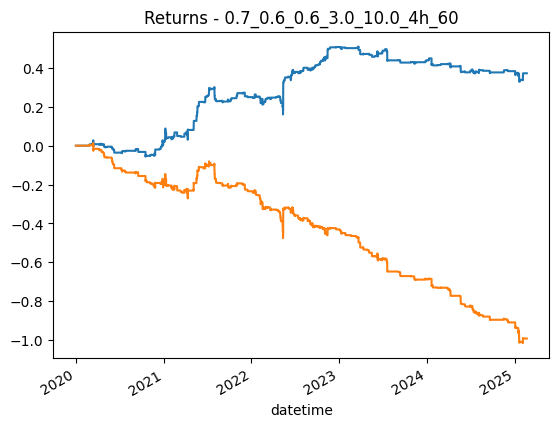

In [18]:
outcome_file = "./iteration_2_return_based_regression_net_results.csv"

outcome_df = pd.read_csv(outcome_file, index_col=0)

net_returns_ser = get_net_return(holdings_df_from_price, price_close_returns)
sharpe_ratio_ser = get_sharpe_ratio_data(net_returns_ser)

new_column = f"{secondary_coin_min_corr}_{tertiary_coin_max_corr}_{rejection_max_corr}_{z_score_min_threshold}_{z_score_max_threshold}_{frequency}_{min_data_points_to_transact}"
outcome_df[new_column] = net_returns_ser

outcome_df.to_csv(outcome_file)

(holdings_df_from_price * price_close_returns).sum(axis=1).cumsum().plot(title=f"Returns - {new_column}")
net_returns_ser.cumsum().plot(title=f"Returns - {new_column}")
sharpe_ratio_ser

In [ ]:
price_close_returns = px_close_4h / px_close_4h.shift() - 1

secondary_coin_min_corr = 0.7
tertiary_coin_max_corr = 0.6
rejection_max_corr = 0.6

z_score_min_threshold = 2.0
z_score_max_threshold = 10.0

min_data_points_to_transact = 10 * 6

frequency = '4h'

holdings_df_from_price = get_holdings_df(
    price_close_returns,
    look_back_min_periods,
    look_back_window_size,
    secondary_coin_min_corr,
    tertiary_coin_max_corr,
    rejection_max_corr,
    min_data_points_to_transact,
    z_score_min_threshold,
    z_score_max_threshold
)

total sr        -3.995456
in-sample sr    -3.507907
out-sample sr   -5.167441
dtype: float64

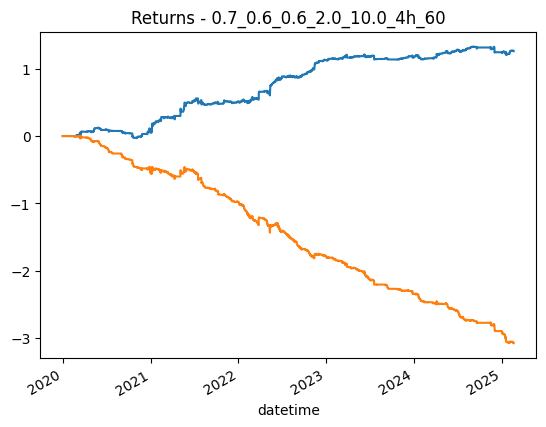

In [20]:
outcome_file = "./iteration_2_return_based_regression_net_results.csv"

outcome_df = pd.read_csv(outcome_file, index_col=0)

net_returns_ser = get_net_return(holdings_df_from_price, price_close_returns)
sharpe_ratio_ser = get_sharpe_ratio_data(net_returns_ser)

new_column = f"{secondary_coin_min_corr}_{tertiary_coin_max_corr}_{rejection_max_corr}_{z_score_min_threshold}_{z_score_max_threshold}_{frequency}_{min_data_points_to_transact}"
outcome_df[new_column] = net_returns_ser

outcome_df.to_csv(outcome_file)

(holdings_df_from_price * price_close_returns).sum(axis=1).cumsum().plot(title=f"Returns - {new_column}")
net_returns_ser.cumsum().plot(title=f"Returns - {new_column}")
sharpe_ratio_ser

In [ ]:
price_close_returns = px_close_4h / px_close_4h.shift() - 1

secondary_coin_min_corr = 0.7
tertiary_coin_max_corr = 0.6
rejection_max_corr = 0.6

z_score_min_threshold = 1.0
z_score_max_threshold = 10.0

min_data_points_to_transact = 10 * 6

frequency = '4h'

holdings_df_from_price = get_holdings_df(
    price_close_returns,
    look_back_min_periods,
    look_back_window_size,
    secondary_coin_min_corr,
    tertiary_coin_max_corr,
    rejection_max_corr,
    min_data_points_to_transact,
    z_score_min_threshold,
    z_score_max_threshold
)

total sr        -10.735350
in-sample sr    -10.451979
out-sample sr   -11.536072
dtype: float64

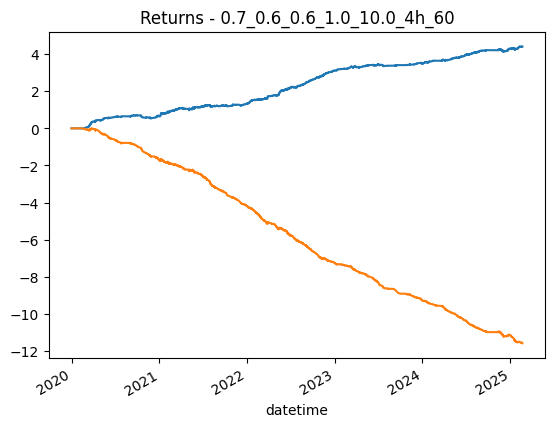

In [22]:
outcome_file = "./iteration_2_return_based_regression_net_results.csv"

outcome_df = pd.read_csv(outcome_file, index_col=0)

net_returns_ser = get_net_return(holdings_df_from_price, price_close_returns)
sharpe_ratio_ser = get_sharpe_ratio_data(net_returns_ser)

new_column = f"{secondary_coin_min_corr}_{tertiary_coin_max_corr}_{rejection_max_corr}_{z_score_min_threshold}_{z_score_max_threshold}_{frequency}_{min_data_points_to_transact}"
outcome_df[new_column] = net_returns_ser

outcome_df.to_csv(outcome_file)

(holdings_df_from_price * price_close_returns).sum(axis=1).cumsum().plot(title=f"Returns - {new_column}")
net_returns_ser.cumsum().plot(title=f"Returns - {new_column}")
sharpe_ratio_ser

# Evaluate Different Sets Of Parameters - 8-Hour Data Frequency

Gross returns are shown in blue. Net returns when taking into account transaction costs are shown in orange.

In [ ]:
price_close_returns = px_close_8h / px_close_8h.shift() - 1

secondary_coin_min_corr = 0.7
tertiary_coin_max_corr = 0.6
rejection_max_corr = 0.6

z_score_min_threshold = 1.0
z_score_max_threshold = 10.0

min_data_points_to_transact = 10 * 6

frequency = '8h'

holdings_df_from_price = get_holdings_df(
    price_close_returns,
    look_back_min_periods,
    look_back_window_size,
    secondary_coin_min_corr,
    tertiary_coin_max_corr,
    rejection_max_corr,
    min_data_points_to_transact,
    z_score_min_threshold,
    z_score_max_threshold
)

total sr        -4.872830
in-sample sr    -4.996320
out-sample sr   -4.716404
dtype: float64

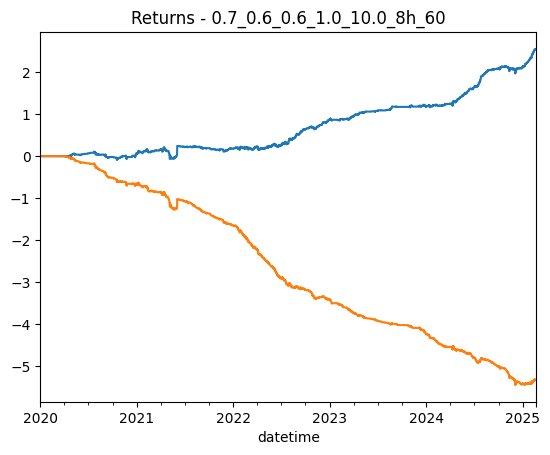

In [27]:
outcome_file = "./iteration_2_return_based_regression_net_results.csv"

outcome_df = pd.read_csv(outcome_file, index_col=0)

net_returns_ser = get_net_return(holdings_df_from_price, price_close_returns)
sharpe_ratio_ser = get_sharpe_ratio_data(net_returns_ser)

new_column = f"{secondary_coin_min_corr}_{tertiary_coin_max_corr}_{rejection_max_corr}_{z_score_min_threshold}_{z_score_max_threshold}_{frequency}_{min_data_points_to_transact}"
outcome_df[new_column] = net_returns_ser

outcome_df.to_csv(outcome_file)

(holdings_df_from_price * price_close_returns).sum(axis=1).cumsum().plot(title=f"Returns - {new_column}")
net_returns_ser.cumsum().plot(title=f"Returns - {new_column}")
sharpe_ratio_ser

In [ ]:
price_close_returns = px_close_8h / px_close_8h.shift() - 1

secondary_coin_min_corr = 0.8
tertiary_coin_max_corr = 0.7
rejection_max_corr = 0.6

z_score_min_threshold = 1.0
z_score_max_threshold = 10.0

min_data_points_to_transact = 5 * 2

frequency = '8h'

holdings_df_from_price = get_holdings_df(
    price_close_returns,
    look_back_min_periods,
    look_back_window_size,
    secondary_coin_min_corr,
    tertiary_coin_max_corr,
    rejection_max_corr,
    min_data_points_to_transact,
    z_score_min_threshold,
    z_score_max_threshold
)

total sr        -4.684457
in-sample sr    -4.181863
out-sample sr   -5.361683
dtype: float64

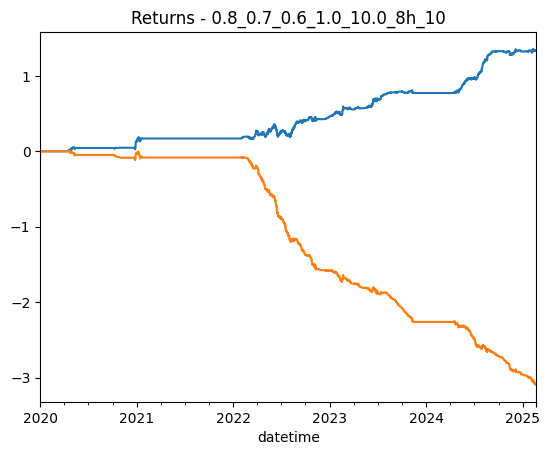

In [33]:
outcome_file = "./iteration_2_return_based_regression_net_results.csv"

outcome_df = pd.read_csv(outcome_file, index_col=0)

net_returns_ser = get_net_return(holdings_df_from_price, price_close_returns)
sharpe_ratio_ser = get_sharpe_ratio_data(net_returns_ser)

new_column = f"{secondary_coin_min_corr}_{tertiary_coin_max_corr}_{rejection_max_corr}_{z_score_min_threshold}_{z_score_max_threshold}_{frequency}_{min_data_points_to_transact}"
outcome_df[new_column] = net_returns_ser

outcome_df.to_csv(outcome_file)

(holdings_df_from_price * price_close_returns).sum(axis=1).cumsum().plot(title=f"Returns - {new_column}")
net_returns_ser.cumsum().plot(title=f"Returns - {new_column}")
sharpe_ratio_ser

In [ ]:
price_close_returns = px_close_8h / px_close_8h.shift() - 1

secondary_coin_min_corr = 0.7
tertiary_coin_max_corr = 0.7
rejection_max_corr = 0.6

z_score_min_threshold = 1.0
z_score_max_threshold = 10.0

min_data_points_to_transact = 5 * 6

frequency = '8h'

holdings_df_from_price = get_holdings_df(
    price_close_returns,
    look_back_min_periods,
    look_back_window_size,
    secondary_coin_min_corr,
    tertiary_coin_max_corr,
    rejection_max_corr,
    min_data_points_to_transact,
    z_score_min_threshold,
    z_score_max_threshold
)

total sr        -6.017419
in-sample sr    -5.242232
out-sample sr   -7.660751
dtype: float64

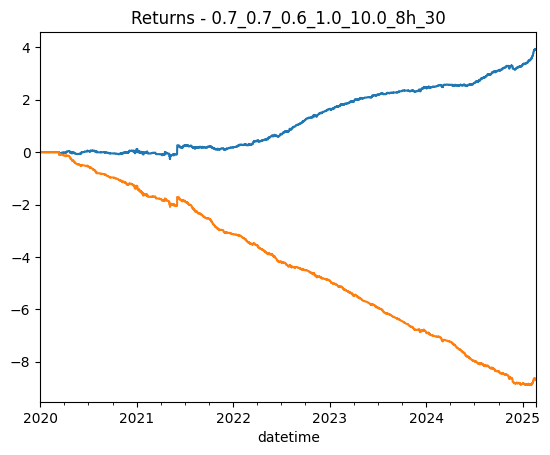

In [35]:
outcome_file = "./iteration_2_return_based_regression_net_results.csv"

outcome_df = pd.read_csv(outcome_file, index_col=0)

net_returns_ser = get_net_return(holdings_df_from_price, price_close_returns)
sharpe_ratio_ser = get_sharpe_ratio_data(net_returns_ser)

new_column = f"{secondary_coin_min_corr}_{tertiary_coin_max_corr}_{rejection_max_corr}_{z_score_min_threshold}_{z_score_max_threshold}_{frequency}_{min_data_points_to_transact}"
outcome_df[new_column] = net_returns_ser

outcome_df.to_csv(outcome_file)

(holdings_df_from_price * price_close_returns).sum(axis=1).cumsum().plot(title=f"Returns - {new_column}")
net_returns_ser.cumsum().plot(title=f"Returns - {new_column}")
sharpe_ratio_ser

In [ ]:
price_close_returns = px_close_8h / px_close_8h.shift() - 1

secondary_coin_min_corr = 0.7
tertiary_coin_max_corr = 0.7
rejection_max_corr = 0.6

z_score_min_threshold = 2.0
z_score_max_threshold = 10.0

min_data_points_to_transact = 5 * 6

frequency = '8h'

holdings_df_from_price = get_holdings_df(
    price_close_returns,
    look_back_min_periods,
    look_back_window_size,
    secondary_coin_min_corr,
    tertiary_coin_max_corr,
    rejection_max_corr,
    min_data_points_to_transact,
    z_score_min_threshold,
    z_score_max_threshold
)

total sr        -2.728937
in-sample sr    -2.925354
out-sample sr   -2.454741
dtype: float64

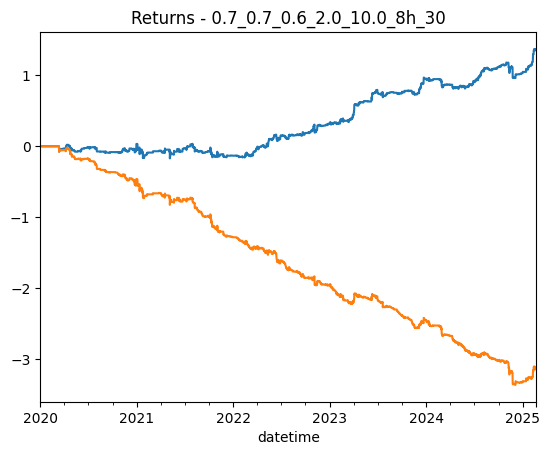

In [37]:
outcome_file = "./iteration_2_return_based_regression_net_results.csv"

outcome_df = pd.read_csv(outcome_file, index_col=0)

net_returns_ser = get_net_return(holdings_df_from_price, price_close_returns)
sharpe_ratio_ser = get_sharpe_ratio_data(net_returns_ser)

new_column = f"{secondary_coin_min_corr}_{tertiary_coin_max_corr}_{rejection_max_corr}_{z_score_min_threshold}_{z_score_max_threshold}_{frequency}_{min_data_points_to_transact}"
outcome_df[new_column] = net_returns_ser

outcome_df.to_csv(outcome_file)

(holdings_df_from_price * price_close_returns).sum(axis=1).cumsum().plot(title=f"Returns - {new_column}")
net_returns_ser.cumsum().plot(title=f"Returns - {new_column}")
sharpe_ratio_ser

In [ ]:
price_close_returns = px_close_8h / px_close_8h.shift() - 1

secondary_coin_min_corr = 0.7
tertiary_coin_max_corr = 0.7
rejection_max_corr = 0.4

z_score_min_threshold = 2.0
z_score_max_threshold = 10.0

min_data_points_to_transact = 5 * 6

frequency = '8h'

holdings_df_from_price = get_holdings_df(
    price_close_returns,
    look_back_min_periods,
    look_back_window_size,
    secondary_coin_min_corr,
    tertiary_coin_max_corr,
    rejection_max_corr,
    min_data_points_to_transact,
    z_score_min_threshold,
    z_score_max_threshold
)

total sr        -2.127733
in-sample sr    -2.714021
out-sample sr   -1.464187
dtype: float64

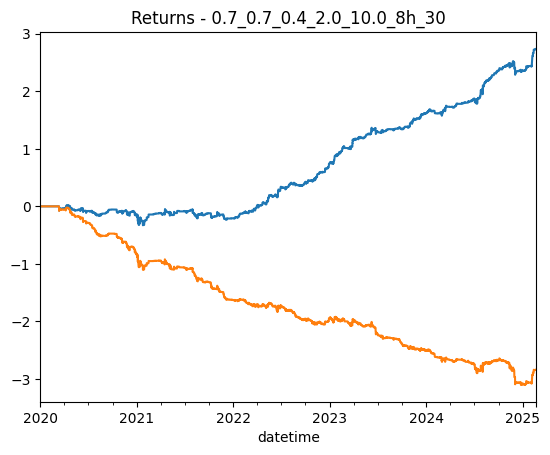

In [39]:
outcome_file = "./iteration_2_return_based_regression_net_results.csv"

outcome_df = pd.read_csv(outcome_file, index_col=0)

net_returns_ser = get_net_return(holdings_df_from_price, price_close_returns)
sharpe_ratio_ser = get_sharpe_ratio_data(net_returns_ser)

new_column = f"{secondary_coin_min_corr}_{tertiary_coin_max_corr}_{rejection_max_corr}_{z_score_min_threshold}_{z_score_max_threshold}_{frequency}_{min_data_points_to_transact}"
outcome_df[new_column] = net_returns_ser

outcome_df.to_csv(outcome_file)

(holdings_df_from_price * price_close_returns).sum(axis=1).cumsum().plot(title=f"Returns - {new_column}")
net_returns_ser.cumsum().plot(title=f"Returns - {new_column}")
sharpe_ratio_ser

In [ ]:
price_close_returns = px_close_8h / px_close_8h.shift() - 1

secondary_coin_min_corr = 0.7
tertiary_coin_max_corr = 0.7
rejection_max_corr = 0.4

z_score_min_threshold = 3.0
z_score_max_threshold = 10.0

min_data_points_to_transact = 5 * 6

frequency = '8h'

holdings_df_from_price = get_holdings_df(
    price_close_returns,
    look_back_min_periods,
    look_back_window_size,
    secondary_coin_min_corr,
    tertiary_coin_max_corr,
    rejection_max_corr,
    min_data_points_to_transact,
    z_score_min_threshold,
    z_score_max_threshold
)